In [1]:
import os
import warnings
from pathlib import Path
import pickle
import joblib

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap


import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, LSTM, GlobalAveragePooling2D,
    Reshape, Concatenate, Bidirectional, concatenate, add
)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence, plot_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam


plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')


WORK_DIR = Path('/kaggle/working')
WORK_DIR.mkdir(parents=True, exist_ok=True)


2025-06-22 11:51:43.490839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750593103.649684      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750593103.693294      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Path to image directory
IMAGE_DIR = '/kaggle/input/flickr30k/Images'

# Load captions file
data = pd.read_csv('/kaggle/input/flickr30k/captions.txt')

data.head()
    

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


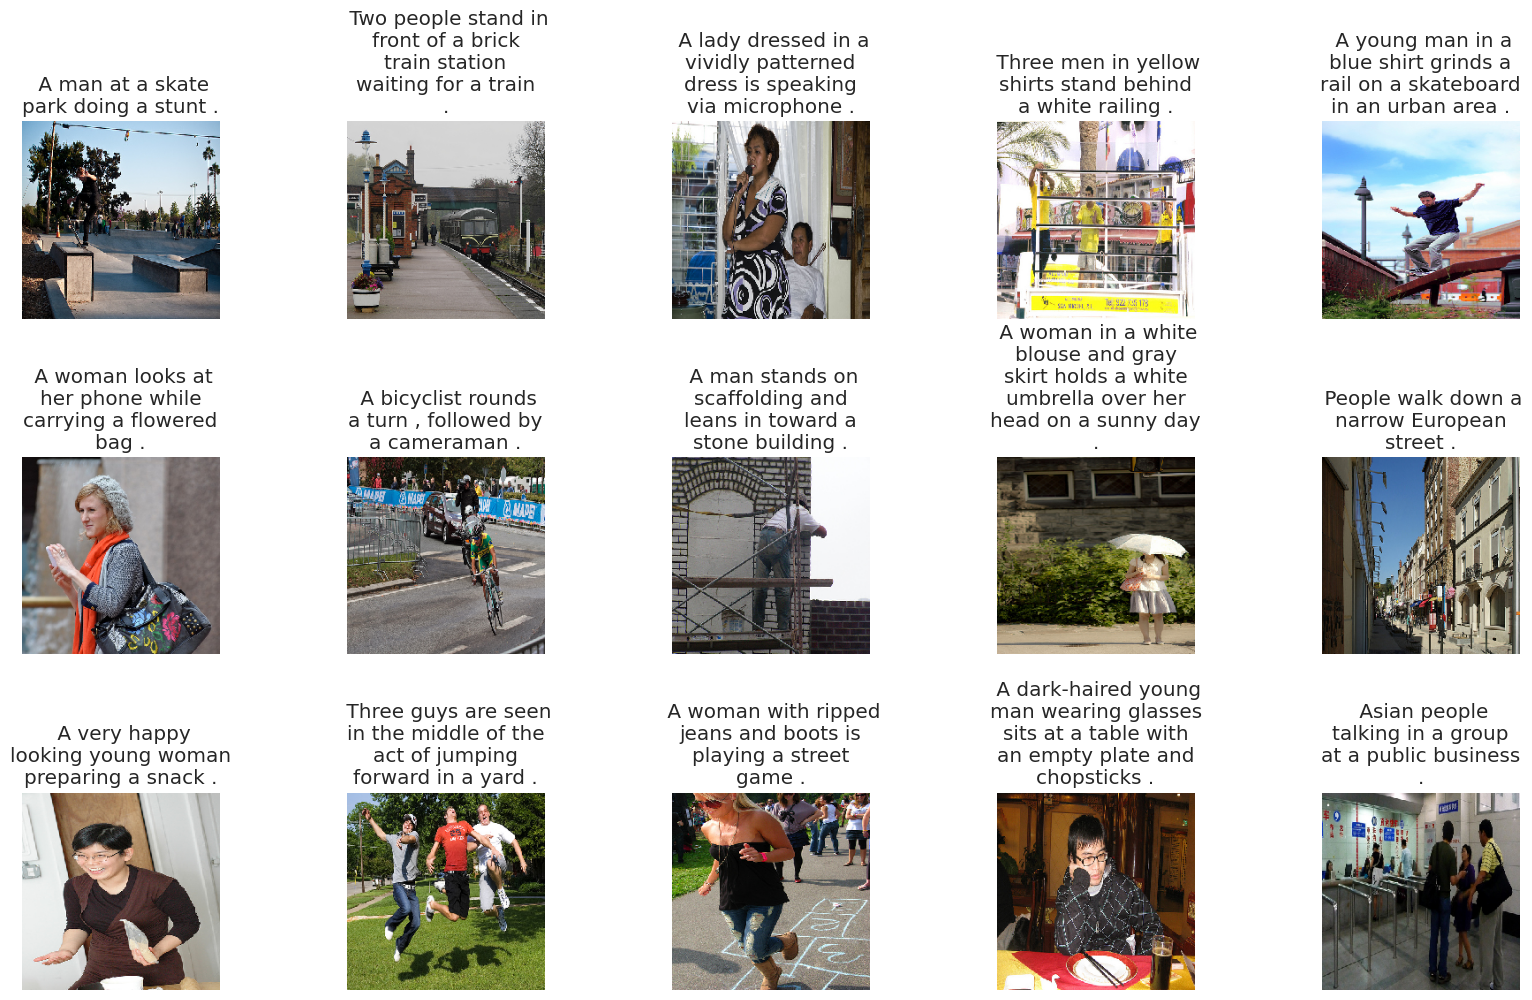

In [3]:
def read_image(path, img_size=224):

    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = eff_preprocess(img)  # EfficientNet expects inputs in range [-1, 1]
    return img

def display_images(temp_df, image_dir=IMAGE_DIR, img_size=224):

    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    for i in range(15):
        plt.subplot(5, 5, i + 1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image_path = Path(image_dir) / temp_df.image[i]
        if image_path.exists():
            image = load_img(image_path, target_size=(img_size, img_size))
            plt.imshow(image)
        else:
            plt.text(0.5, 0.5, 'Image not found', ha='center')
        caption = "\n".join(wrap(str(temp_df.caption[i]), 20))
        plt.title(caption)
        plt.axis("off")

display_images(data.sample(15))


In [4]:
import re
def text_preprocessing(data):
    # Ensure all captions are strings and not NaN
    data['caption'] = data['caption'].fillna('').astype(str)

    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"[^A-Za-z\s]", "", x))  # regex fix
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"\s+", " ", x))         # regex fix
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    data['caption'] = data['caption'].apply(lambda x: "startseq " + x + " endseq")

    return data
data = text_preprocessing(data)
captions = data['caption'].tolist()
print(captions[:10])


['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq', 'startseq two young white males are outside near many bushes endseq', 'startseq two men in green shirts are standing in yard endseq', 'startseq man in blue shirt standing in garden endseq', 'startseq two friends enjoy time spent together endseq', 'startseq several men in hard hats are operating giant pulley system endseq', 'startseq workers look down from up above on piece of equipment endseq', 'startseq two men working on machine wearing hard hats endseq', 'startseq four men on top of tall structure endseq', 'startseq three men on large rig endseq']


In [5]:
# Fit tokenizer on all captions
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(captions)

vocab_size = len(tokenizer.word_index) + 1

max_length = max(len(caption.split()) for caption in captions)
print(f"Vocabulary Size: {vocab_size}")
print(f"Max Caption Length: {max_length}")

images = data['image'].unique().tolist()
nimages = len(images)

# Train-validation split (85-15)
split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

# Filter captions into train and test sets
train = data[data['image'].isin(train_images)].reset_index(drop=True)
test = data[data['image'].isin(val_images)].reset_index(drop=True)

# Preview: Tokenized caption
example_seq = tokenizer.texts_to_sequences([captions[1]])[0]
print("Example sequence:", example_seq)
import pickle

tokenizer_path = "tokenizer.pkl"     
with open(tokenizer_path, "wb") as f:  
    pickle.dump(tokenizer, f)

print(f"Tokenizer saved to {tokenizer_path}")


Vocabulary Size: 19751
Max Caption Length: 74
Example sequence: [2, 13, 20, 21, 704, 14, 55, 80, 193, 1416, 3]
Tokenizer saved to tokenizer.pkl


In [6]:
# Build EfficientNetB0 base
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
fe_model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Feature extraction settings
img_size = 224
features = {}

# Loop through unique images
for image_name in tqdm(data['image'].unique(), desc='Extracting EfficientNet features'):
    img_path = Path(IMAGE_DIR) / image_name

    # Load and preprocess image
    img = load_img(img_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array = eff_preprocess(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract feature
    feature_vector = fe_model.predict(img_array, verbose=0)
    features[image_name] = feature_vector.squeeze()  # Remove batch dimension

model_path = Path("feature_extractor.keras")
fe_model.save(model_path)
print(f"Feature-extractor saved to: {model_path.resolve()}")

I0000 00:00:1750593121.784710      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750593121.785376      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting EfficientNet features:   0%|          | 0/31783 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1750593127.695821     102 service.cc:148] XLA service 0x7dd240001510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750593127.696533     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750593127.696554     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750593128.389323     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750593132.776651     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting EfficientNet features: 100%|██████████| 31783/31783 [48:37<00:00, 10.89it/s] 


Feature-extractor saved to: /kaggle/working/feature_extractor.keras


In [7]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.image_caption_map = self.df.groupby(self.X_col)[self.y_col].apply(list).to_dict()
        self.image_list = list(self.image_caption_map.keys())
        self.n = len(self.image_list)
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_list)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        # Get batch image names
        batch_images = self.image_list[index * self.batch_size : (index + 1) * self.batch_size]
        X1, X2, y = self.__get_data(batch_images)
        return (X1, X2), y

    def __get_data(self, batch_images):
        X1, X2, y = [], [], []

        for image in batch_images:
            feature = self.features[image]  # shape: (1280,)
            captions = self.image_caption_map[image]

            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical(out_seq, num_classes=self.vocab_size)

                    X1.append(feature)        # image feature
                    X2.append(in_seq)        # text input sequence
                    y.append(out_seq)        # next word in sequence

        return np.array(X1), np.array(X2), np.array(y)
train_generator = CustomDataGenerator(
    df=train,
    X_col='image',
    y_col='caption',
    batch_size=64,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
)

validation_generator = CustomDataGenerator(
    df=test,
    X_col='image',
    y_col='caption',
    batch_size=64,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features
)


In [8]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, LSTM,
    Reshape, concatenate, add
)

feature_dim = 1280        

# ----- Inputs -----
image_input   = Input(shape=(feature_dim,),  name="img_feat")      # (None, 1280)
caption_input = Input(shape=(max_length,),  name="txt_seq")        # (None, max_len)

# ----- Image branch -----
img_dense   = Dense(256, activation='relu')(image_input)           # (None, 256)
img_reshape = Reshape((1, 256))(img_dense)                         # (None, 1, 256)

# ----- Text branch -----
txt_embed = Embedding(vocab_size, 256, mask_zero=False)(caption_input)  # (None, max_len, 256)

# ----- Fusion -----
merged = concatenate([img_reshape, txt_embed], axis=1)             # (None, 1+max_len, 256)
txt_lstm = LSTM(256)(merged)                                       # (None, 256)

# ----- Residual + Classifier -----
x = Dropout(0.5)(txt_lstm)
x = add([x, img_dense])                                            # residual
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[image_input, caption_input], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

caption_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_feat (InputLayer)     │ (None, 1280)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        327,936 │ img_feat[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ txt_seq (InputLayer)      │ (None, 74)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 74, 256)        │      5,056,256 │ txt_seq[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 75, 256)        │              0 │ reshape[0][0],         │
│                           │                        │                │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dropout[0][0],         │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 19751)          │      2,547,879 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,490,279 (32.39 MB)

 Trainable params: 8,490,279 (32.39 MB)

 Non-trainable params: 0 (0.00 B)

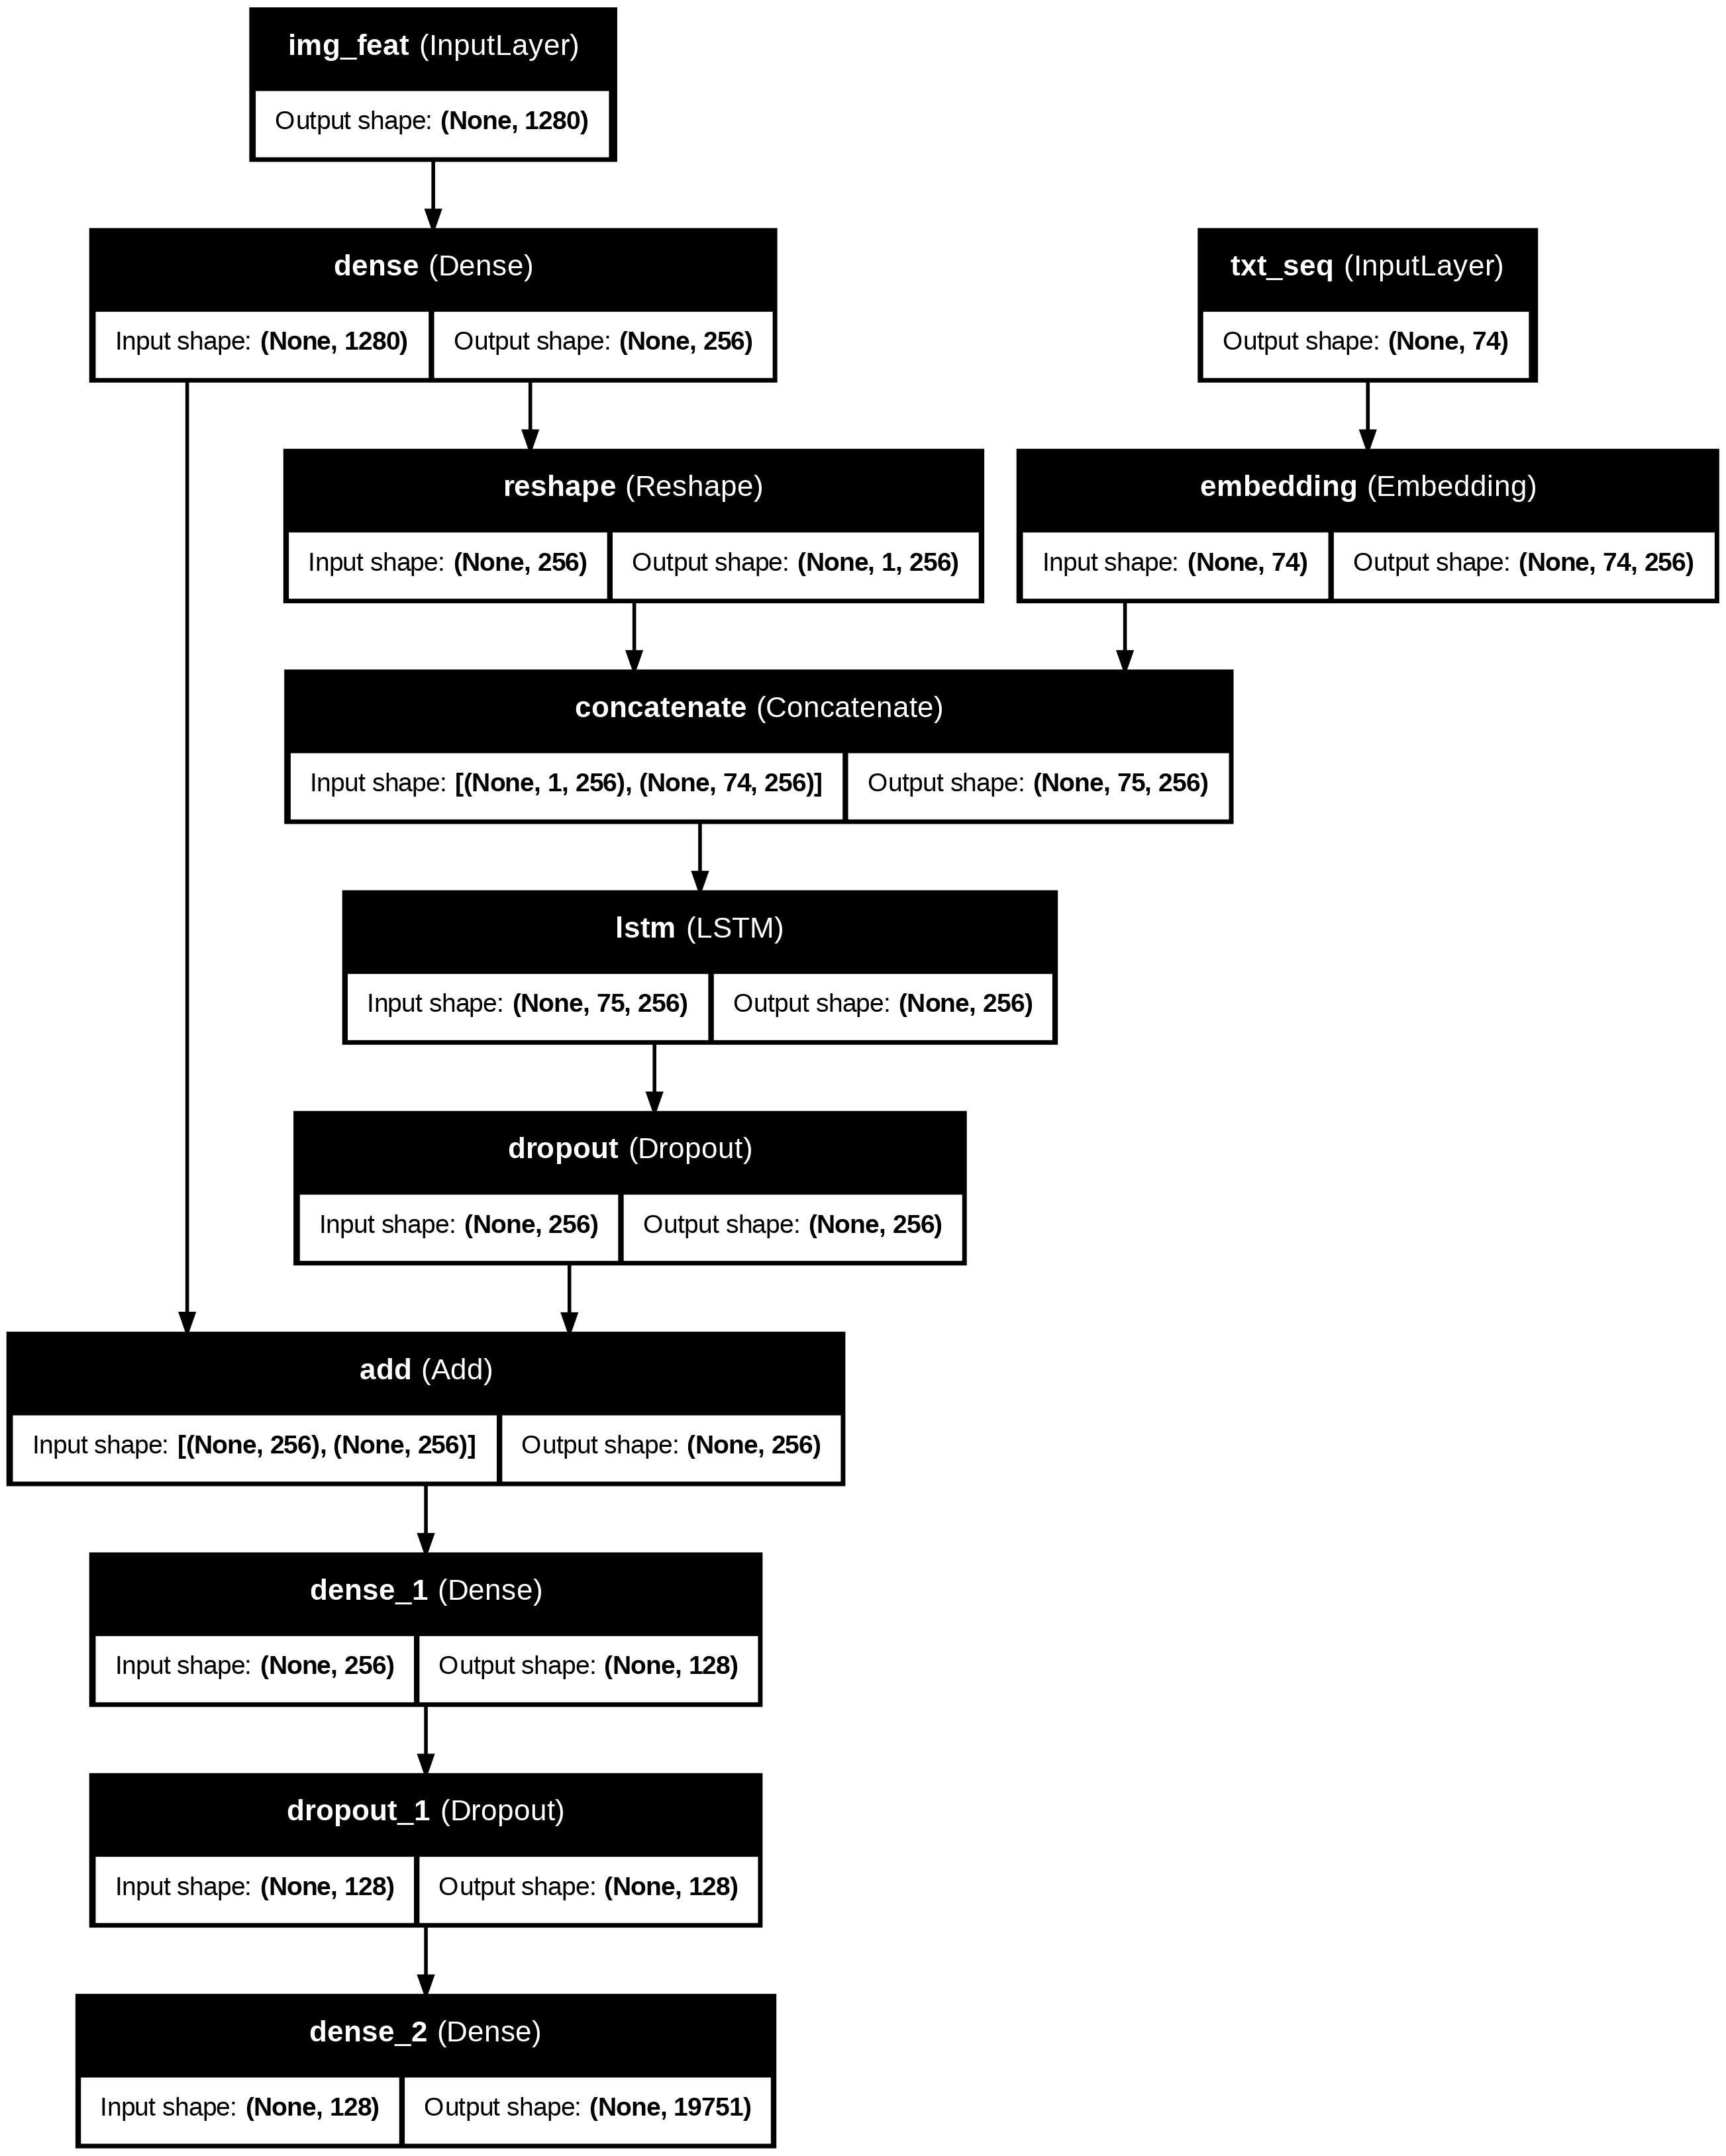

In [9]:
from tensorflow.keras.utils import plot_model

plot_model(
    caption_model,
    to_file="caption_model.png",        # saves to file
    show_shapes=True,                   # display input/output shapes
    show_layer_names=True,              # display layer names
    expand_nested=False
)


In [11]:


feature_dim = 1280  # EfficientNetB0 + GlobalAveragePooling2D output

# Define inputs
input1 = Input(shape=(feature_dim,), name='image_features')        # (None, 1280)
input2 = Input(shape=(max_length,), name='text_sequence')          # (None, max_len)

# Image feature branch
img_features = Dense(256, activation='relu')(input1)               # (None, 256)
img_features_reshaped = Reshape((1, 256))(img_features)            # (None, 1, 256)

# Text feature branch
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)  # (None, max_len, 256)

# Merge and decode
merged = concatenate([img_features_reshaped, sentence_features], axis=1) # (None, 1+max_len, 256)
sentence_features = LSTM(256)(merged)                                     # (None, 256)

# Classifier
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])  # residual connection
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

# Build and compile model
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Optional: visualize model
# plot_model(caption_model, show_shapes=True, to_file='model_structure.png')

# Callbacks
checkpoint = ModelCheckpoint(
    "model.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=1e-8
)

# Train the model
history = caption_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - loss: 6.1579
Epoch 1: val_loss improved from inf to 4.87049, saving model to model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - loss: 6.1562 - val_loss: 4.8705 - learning_rate: 0.0010
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - loss: 4.6164
Epoch 2: val_loss improved from 4.87049 to 4.50309, saving model to model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - loss: 4.6163 - val_loss: 4.5031 - learning_rate: 0.0010
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - loss: 4.3379
Epoch 3: val_loss improved from 4.50309 to 4.35147, saving model to model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - loss: 4.3379 - val_loss: 4.3515 - learning_rate: 0.0010
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - loss: 4.1836
Epoch 4: val_loss improved from 4.35147 to 4.26741, saving model to model.keras
422/422 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - loss: 4.1836 - val_loss: 4.2674 - learning_rate: 0.0010
Epoch 5/

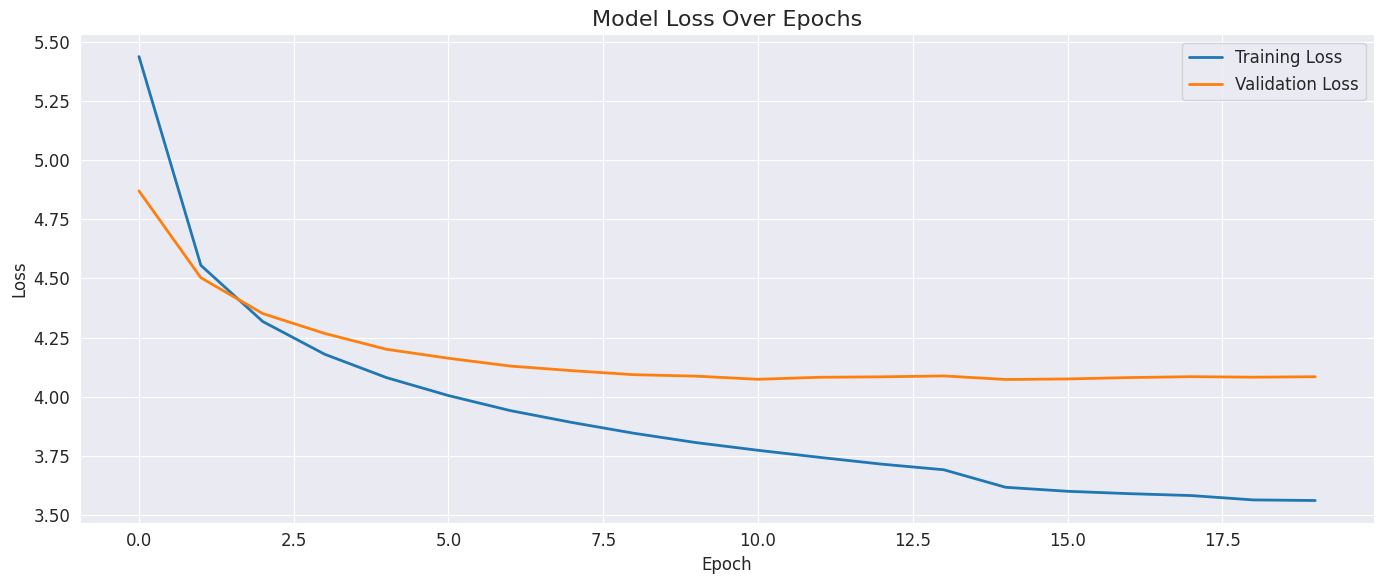

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:


def generate_and_display_caption(image_path, model_path="model.keras", tokenizer_path="tokenizer.pkl", feature_extractor_path="feature_extractor.keras", max_length=74, img_size=224):
    # Load the trained caption model, EfficientNet feature extractor, and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image using EfficientNet preprocessing
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array = eff_preprocess(img_array)  # EfficientNet-specific normalization
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract image features
    image_features = feature_extractor.predict(img_array, verbose=0)
    image_features = np.squeeze(image_features)  # Remove batch dim if needed

    # Start caption generation
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict next word
        yhat = caption_model.predict([np.expand_dims(image_features, axis=0), sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index)

        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break

    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image and caption
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()


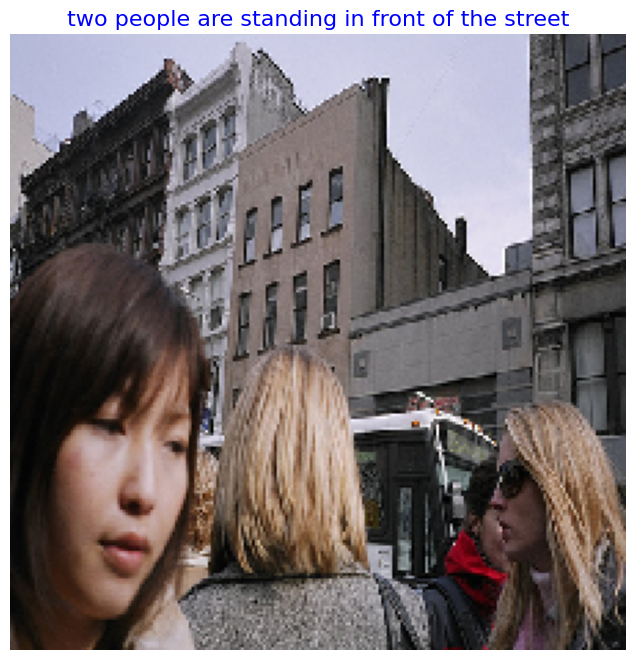

In [19]:
# Example usage
image_path = "/kaggle/input/flickr30k/Images/100197432.jpg"  # Provide valid image path

# Generate and display caption
generate_and_display_caption(
    image_path=image_path
)


In [22]:

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


# ── PATHS  
IMAGE_DIR     = "/kaggle/input/flickr30k/Images"   # folder with .jpg files
CAPTIONS_FILE = "/kaggle/input/flickr30k/captions.txt"
WORKING_DIR   = "/kaggle/working"                 # holds model.keras, tokenizer.pkl

#  ── Load model, feature extractor, tokenizer
caption_model     = load_model(os.path.join(WORKING_DIR, "model.keras"))
feature_extractor = load_model(os.path.join(WORKING_DIR, "feature_extractor.keras"))
with open(os.path.join(WORKING_DIR, "tokenizer.pkl"), "rb") as f:
    tokenizer = pickle.load(f)

max_length = 74  # ← keep consistent with training

#  ── Build captions_dict 
captions_dict, bad_lines = {}, 0
with open(CAPTIONS_FILE, "r", encoding="utf-8") as f:
    for raw in f:
        line = raw.strip()
        if not line or ',' not in line:
            bad_lines += 1
            continue
        try:
            img_file, caption = line.split(",", 1)
            img_file = img_file.strip().lower()
            caption = caption.strip()
            captions_dict.setdefault(img_file, []).append(caption)
        except ValueError:
            bad_lines += 1

print(f"Loaded captions for {len(captions_dict)} images "
      f"(skipped {bad_lines} malformed lines).")


# 5 ── Train/validation split (85 / 15)
all_imgs  = list(captions_dict.keys())
split_idx = round(0.85 * len(all_imgs))
val_imgs  = all_imgs[split_idx:]
print(f"Validation set: {len(val_imgs)} images")

# 6 ── Caption generator (greedy)
def generate_caption(img_path):
    img_arr = eff_preprocess(img_to_array(load_img(img_path, target_size=(224, 224))))
    feat    = feature_extractor.predict(img_arr[None, ...], verbose=0).squeeze()

    text = "startseq"
    for _ in range(max_length):
        seq  = pad_sequences([tokenizer.texts_to_sequences([text])[0]], maxlen=max_length)
        yhat = caption_model.predict([feat[None, :], seq], verbose=0)
        word = tokenizer.index_word.get(int(np.argmax(yhat)))
        if word is None or word == "endseq":
            break
        text += " " + word
    return text.replace("startseq", "").strip()

#  ── Evaluate BLEU‑1 & BLEU‑4  

smooth = SmoothingFunction().method4
refs, hyps = [], []
skip_img, skip_pred = 0, 0

for fname in tqdm(val_imgs, desc="Evaluating"):
    path = os.path.join(IMAGE_DIR, fname.lower())  # ← lookup lowercase
    if not os.path.exists(path):
        skip_img += 1
        continue

    pred = generate_caption(path).split()
    gt   = [c.split() for c in captions_dict.get(fname, [])]

    if not pred or not gt:        # skip empty cases
        skip_pred += 1
        continue

    hyps.append(pred)
    refs.append(gt)

print(f"\nImages skipped (not found): {skip_img}")
print(f"Skipped due to empty pred/gt: {skip_pred}")
print(f"Evaluated pairs:             {len(hyps)}")

if not hyps:
    print("\n⚠️  No valid predictions — BLEU cannot be computed.")
else:
    bleu1 = corpus_bleu(refs, hyps, weights=(1, 0, 0, 0),               smoothing_function=smooth)
    bleu4 = corpus_bleu(refs, hyps, weights=(0.25, 0.25, 0.25, 0.25),   smoothing_function=smooth)

    print("\n--- Validation BLEU Scores ---")
    print(f"BLEU‑1: {bleu1:.4f}")
    print(f"BLEU‑4: {bleu4:.4f}")


Loaded captions for 31784 images (skipped 0 malformed lines).
Validation set: 4768 images


Evaluating: 100%|██████████| 4768/4768 [1:08:15<00:00,  1.16it/s]



Images skipped (not found): 0
Skipped due to empty pred/gt: 0
Evaluated pairs:             4768

--- Validation BLEU Scores ---
BLEU‑1: 0.4624
BLEU‑4: 0.0659
